Processing NVDA...


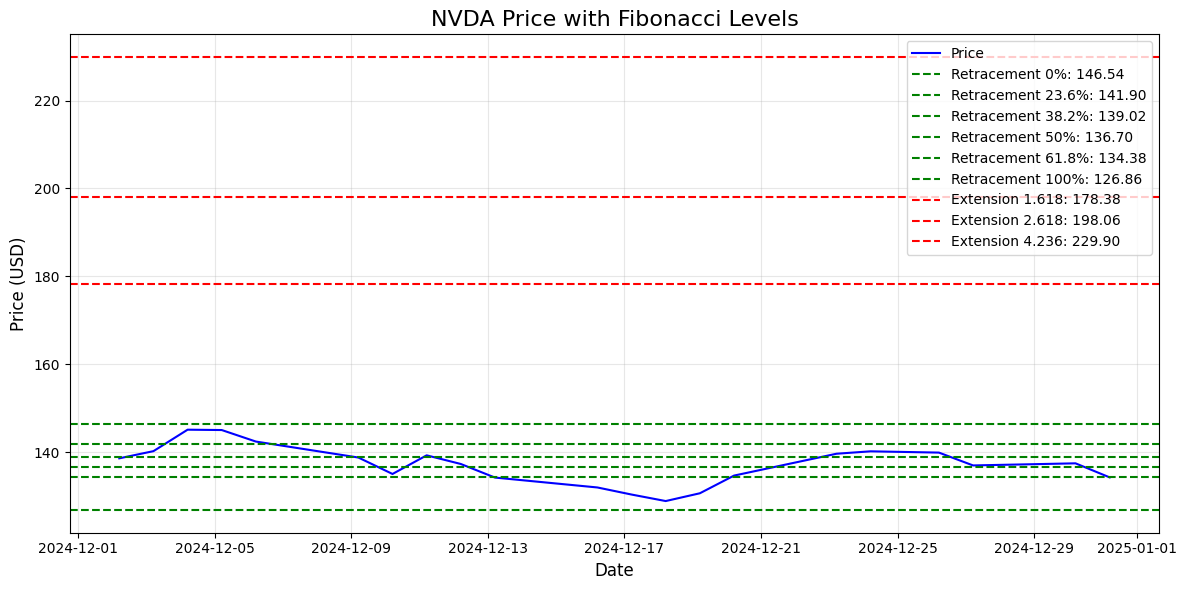

Processing IONQ...


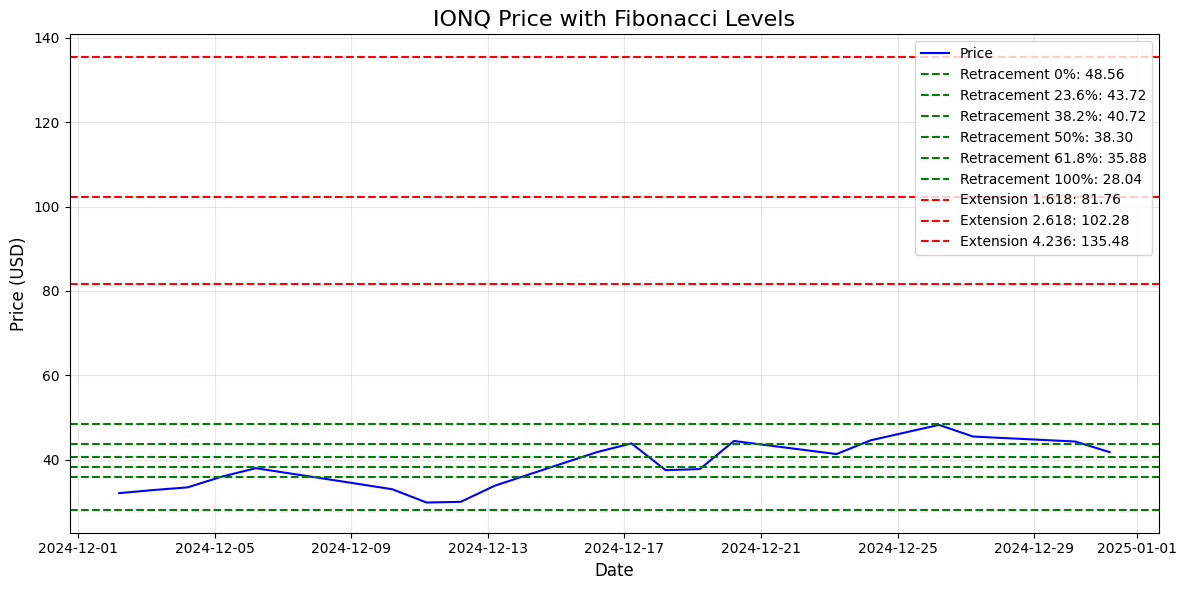

In [9]:
import alpaca_trade_api as tradeapi
import pandas as pd
import matplotlib.pyplot as plt
from alpaca_trade_api import REST  # Import Alpaca REST API

from dotenv import load_dotenv
import os
from pytz import timezone

# Load environment variables from .env file
load_dotenv('/home/developer/projects/myML/.env')

# Retrieve environment variables
API_KEY = os.getenv('APCA_API_KEY_ID')
SECRET_KEY = os.getenv('APCA_API_SECRET_KEY')
BASE_URL = os.getenv('APCA_API_BASE_URL')

# Initialize Alpaca REST client
api = REST(API_KEY, SECRET_KEY, BASE_URL, api_version="v2")


# Fetch historical data from Alpaca
def fetch_stock_data(symbol, timeframe, start_date, end_date):
    """
    Fetch historical OHLC data for a stock using Alpaca API.
    Args:
        symbol (str): Stock symbol (e.g., 'NVDA').
        timeframe (str): Timeframe for bars (e.g., '1Day').
        start_date (str): Start date (YYYY-MM-DD).
        end_date (str): End date (YYYY-MM-DD).
    Returns:
        pd.DataFrame: DataFrame containing historical OHLC data.
    """
    bars = api.get_bars(symbol, tradeapi.TimeFrame.Day, start=start_date, end=end_date).df
    bars.reset_index(inplace=True)
    bars = bars[["timestamp", "open", "high", "low", "close"]]
    bars["timestamp"] = pd.to_datetime(bars["timestamp"])
    return bars

# Calculate Fibonacci levels
def calculate_fibonacci_levels(swing_high, swing_low):
    diff = swing_high - swing_low
    retracements = {
        "0%": swing_high,
        "23.6%": swing_high - 0.236 * diff,
        "38.2%": swing_high - 0.382 * diff,
        "50%": swing_high - 0.5 * diff,
        "61.8%": swing_high - 0.618 * diff,
        "100%": swing_low,
    }
    extensions = {
        "1.618": swing_high + 1.618 * diff,
        "2.618": swing_high + 2.618 * diff,
        "4.236": swing_high + 4.236 * diff,
    }
    return retracements, extensions

# Plot Fibonacci levels
def plot_fibonacci_levels(symbol, data, retracements, extensions):
    plt.figure(figsize=(12, 6))
    plt.plot(data["timestamp"], data["close"], label="Price", color="blue")

    # Plot retracement levels
    for level, price in retracements.items():
        plt.axhline(price, linestyle="--", color="green", label=f"Retracement {level}: {price:.2f}")

    # Plot extension levels
    for level, price in extensions.items():
        plt.axhline(price, linestyle="--", color="red", label=f"Extension {level}: {price:.2f}")

    # Add chart details
    plt.title(f"{symbol} Price with Fibonacci Levels", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price (USD)", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{symbol}_fibonacci_chart.png")
    plt.show()

# Symbols to process
symbols = ["NVDA", "IONQ"]
start_date = "2024-12-01"
end_date = "2025-01-01"

# Loop through each stock symbol
for symbol in symbols:
    print(f"Processing {symbol}...")
    data = fetch_stock_data(symbol, "1Day", start_date, end_date)

    if not data.empty:
        # Calculate Fibonacci levels
        swing_high = data["high"].max()
        swing_low = data["low"].min()
        retracements, extensions = calculate_fibonacci_levels(swing_high, swing_low)

        # Plot Fibonacci levels
        plot_fibonacci_levels(symbol, data, retracements, extensions)
    else:
        print(f"No data available for {symbol}.")
